In [ ]:
#| default_exp 86-distillation-for-wikiseealso-with-oak-1-0

In [ ]:
%load_ext autoreload
%autoreload 2

from nbdev.showdoc import *
import nbdev; nbdev.nbdev_export()

In [ ]:
#| export
import os,torch, torch.multiprocessing as mp, pickle, numpy as np
from transformers import DistilBertConfig

from xcai.basics import *
from xcai.models.oak import OAK003
from xcai.models.distillation import DTL004,TCH001,TCH002

from xclib.utils.sparse import retain_topk

comet_ml is installed but `COMET_API_KEY` is not set.


In [ ]:
mm = {'test_loss': 0.01858418621122837, 'test_P@1': 0.31203560262513025, 'test_P@10': 0.09995211672259655, 'test_P@3': 0.20779276868618216, 'test_P@5': 0.15723178322975181, 'test_N@1': 0.31203559041023254, 'test_N@10': 0.340093195438385, 'test_N@3': 0.31047287583351135, 'test_N@5': 0.3209989368915558, 'test_PSP@1': 0.2519946678997244, 'test_PSP@10': 0.33508594871269065, 'test_PSP@3': 0.2709502810292651, 'test_PSP@5': 0.2917879189664694, 'test_PSN@1': 0.25199466943740845, 'test_PSN@10': 0.3138096332550049, 'test_PSN@3': 0.2754184603691101, 'test_PSN@5': 0.29206395149230957, 'test_R@200': 0.5681039232401093, 'test_R@10': 0.3878999434335421, 'test_R@100': 0.5342460762489158, 'test_runtime': 4884.3592, 'test_samples_per_second': 36.344, 'test_steps_per_second': 0.364}

display_metric(mm)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@10,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,31.2036,20.7793,15.7232,9.9952,31.2036,31.0473,32.0999,34.0093,25.1995,27.095,29.1788,33.5086,25.1995,27.5418,29.2064,31.381,38.79,53.4246,56.8104,0.0186,4884.3592,36.344,0.364


In [ ]:
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
#| export
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ['WANDB_PROJECT']='xc-nlg_83-oak-dr-ep-for-wikiseealso'

In [ ]:
data_dir = '/home/scai/phd/aiz218323/Projects/XC_NLG/data'

block = XCBlock.from_cfg(data_dir, 'data_meta', tfm='rm', tokenizer='distilbert-base-uncased', 
                         smp_features=[('lbl2data|cat2lbl2data', 1, (2,1)), ('cat2data',1,1)])

In [ ]:
#| export
pkl_dir = '/home/scai/phd/aiz218323/scratch/datasets/'
pkl_file = f'{pkl_dir}/processed/wikiseealso_data-metas_distilbert-base-uncased_rm_radga-cat-linker.pkl'

In [ ]:
#| export
with open(pkl_file, 'rb') as file: block = pickle.load(file)

## Training

In [ ]:
#| export
args = XCLearningArguments(
    output_dir='/home/scai/phd/aiz218323/scratch/outputs/86-distillation-for-wikiseealso-with-oak-1-0',
    logging_first_step=True,
    per_device_train_batch_size=800,
    per_device_eval_batch_size=800,
    representation_num_beams=200,
    representation_accumulation_steps=10,
    save_strategy="steps",
    evaluation_strategy="steps",
    eval_steps=5000,
    save_steps=5000,
    save_total_limit=5,
    num_train_epochs=300,
    predict_with_representation=True,
    adam_epsilon=1e-6,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-4,
    generation_num_beams=10,
    generation_length_penalty=1.5,
    predict_with_generation=True,
    representation_search_type='BRUTEFORCE',
    
    output_representation_attribute='data_fused_repr',
    label_representation_attribute='data_repr',
    metadata_representation_attribute='data_repr',
    data_augmentation_attribute='data_repr',
    representation_attribute='data_fused_repr',
    clustering_representation_attribute='data_fused_repr',

    group_by_cluster=True,
    num_clustering_warmup_epochs=10,
    num_cluster_update_epochs=5,
    num_cluster_size_update_epochs=25,
    use_data_metadata_for_clustering=True,
    clustering_type='EXPO',
    minimum_cluster_size=2,
    maximum_cluster_size=1600,

    metric_for_best_model='P@1',
    load_best_model_at_end=True,
    target_indices_key='plbl2data_idx',
    target_pointer_key='plbl2data_data2ptr',
    
    use_distributional_representation=False,
    use_encoder_parallel=True,
    max_grad_norm=None, 
    fp16=True,
    
    label_names=['lbl2data_idx', 'lbl2data_input_ids', 'lbl2data_attention_mask', 
                 'lnk2data_idx', 'lnk2data_input_ids', 'lnk2data_attention_mask'],
    
    prune_metadata=False,
    num_metadata_prune_warmup_epochs=10,
    num_metadata_prune_epochs=5,
    metadata_prune_batch_size=2048,
    prune_metadata_names=['lnk_meta'],
    use_data_metadata_for_pruning=True,

    predict_with_augmentation=False,
    use_augmentation_index_representation=True,

    data_aug_meta_name='lnk',
    augmentation_num_beams=3,
    data_aug_prefix='lnk',
    use_label_metadata=False,
    
    data_meta_batch_size=2048,
    augment_metadata=False,
    num_metadata_augment_warmup_epochs=10,
    num_metadata_augment_epochs=5,
)


In [ ]:
#| export
model_output = '/home/scai/phd/aiz218323/scratch/outputs/67-ngame-ep-for-wikiseealso-with-input-concatenation-1-4'
m_teacher = TCH001.from_pretrained(f'{model_output}/teacher', n_data=block.train.dset.n_data, n_lbl=block.n_lbl)

m_teacher.freeze_embeddings()
m_teacher.freeze_data_embeddings()

In [ ]:
#| export
model_output = '/home/scai/phd/aiz218323/scratch/outputs/67-ngame-ep-for-wikiseealso-with-input-concatenation-1-4'
m_teacher = TCH002.from_pretrained(f'{model_output}/teacher', n_data=block.train.dset.n_data, n_lbl=block.n_lbl)

m_teacher.freeze_representations()
m_teacher.init_lbl_embeddings()

Some weights of TCH002 were not initialized from the model checkpoint at /home/scai/phd/aiz218323/scratch/outputs/67-ngame-ep-for-wikiseealso-with-input-concatenation-1-4/teacher and are newly initialized: ['lbl_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#| export
bsz = max(args.per_device_train_batch_size, args.per_device_eval_batch_size)*torch.cuda.device_count()

m_student = OAK003.from_pretrained('sentence-transformers/msmarco-distilbert-base-v4', batch_size=bsz, num_batch_labels=5000,
                                   margin=0.3, num_negatives=5, tau=0.1, apply_softmax=True,
                                   
                                   data_aug_meta_prefix='lnk2data', lbl2data_aug_meta_prefix=None,
                                   data_pred_meta_prefix=None, lbl2data_pred_meta_prefix=None,
                                   
                                   num_metadata=block.train.dset.meta['lnk_meta'].n_meta, resize_length=5000,
                                   
                                   calib_margin=0.05, calib_num_negatives=10, calib_tau=0.1, calib_apply_softmax=False,
                                   calib_loss_weight=0.1, use_calib_loss=True,
                                   
                                   use_query_loss=True,
                                   
                                   meta_loss_weight=0.0,
                                   
                                   fusion_loss_weight=0.1, use_fusion_loss=False,
                                   
                                   use_encoder_parallel=False)
m_student.init_retrieval_head()
m_student.init_cross_head()
m_student.init_meta_embeddings()

meta_embed_file = '/home/aiscuser/scratch/OGB_Weights/LF-WikiSeeAlsoTitles-320K/emb_weights.npy'
# meta_embeddings = np.load(meta_embed_file)
# m_student.encoder.set_pretrained_meta_embeddings(torch.tensor(meta_embeddings, dtype=torch.float32))

m_student.encoder.set_pretrained_meta_embeddings(torch.zeros(block.train.dset.meta['lnk_meta'].n_meta, m_student.config.dim))
m_student.encoder.freeze_pretrained_meta_embeddings()

Some weights of OAK003 were not initialized from the model checkpoint at sentence-transformers/msmarco-distilbert-base-v4 and are newly initialized: ['encoder.cross_head.k.bias', 'encoder.cross_head.k.weight', 'encoder.cross_head.o.bias', 'encoder.cross_head.o.weight', 'encoder.cross_head.q.bias', 'encoder.cross_head.q.weight', 'encoder.cross_head.v.bias', 'encoder.cross_head.v.weight', 'encoder.dr_fused_head.layer_norm.bias', 'encoder.dr_fused_head.layer_norm.weight', 'encoder.dr_fused_head.projector.bias', 'encoder.dr_fused_head.projector.weight', 'encoder.dr_fused_head.transform.bias', 'encoder.dr_fused_head.transform.weight', 'encoder.dr_head.layer_norm.bias', 'encoder.dr_head.layer_norm.weight', 'encoder.dr_head.projector.bias', 'encoder.dr_head.projector.weight', 'encoder.dr_head.transform.bias', 'encoder.dr_head.transform.weight', 'encoder.meta_embeddings.weight', 'encoder.meta_head.layer_norm.bias', 'encoder.meta_head.layer_norm.weight', 'encoder.meta_head.projector.bias', 'enc

In [ ]:
#| export
model = DTL004(DistilBertConfig(), m_student=m_student, m_teacher=m_teacher, bsz=bsz, tn_targ=5000, margin=0.3, tau=0.1, 
               n_negatives=10, apply_softmax=True, teacher_data_student_label_loss_weight=1.0, 
               student_data_teacher_label_loss_weight=1.0, data_mse_loss_weight=0.1, label_mse_loss_weight=0.1)


In [ ]:
#| export
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[10, 100, 200])

In [ ]:
#| export
learn = XCLearner(
    model=model, 
    args=args,
    train_dataset=block.train.dset,
    eval_dataset=block.test.dset,
    data_collator=block.collator,
    compute_metrics=metric,
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
#| export
if __name__ == '__main__':
    mp.freeze_support()
    learn.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,P@1,P@10,P@3,P@5,N@1,N@10,N@3,N@5,Psp@1,Psp@10,Psp@3,Psp@5,Psn@1,Psn@10,Psn@3,Psn@5,R@200,R@10,R@100
10,0.078800,0.086276,0.175101,0.056812,0.115025,0.087132,0.175101,0.194849,0.173305,0.180583,0.163741,0.209324,0.168619,0.180018,0.163741,0.201765,0.174354,0.185467,0.429889,0.235065,0.384685


  0%|          | 0/15617 [00:00<?, ?it/s]

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


  0%|          | 0/15617 [00:00<?, ?it/s]

In [ ]:
o = learn.predict(block.test.dset)

  0%|          | 0/196 [00:00<?, ?it/s]

/scratch/scai/phd/aiz218323/Projects/xcai/xcai/losses.py:22: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(data_ptr, data_idx, scores, device=data_ptr.device)


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
display_metric(o.metrics)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@10,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,17.296,11.305,8.5469,5.5415,17.296,17.0792,17.7819,19.1372,16.3694,16.7477,17.8326,20.6162,16.3694,17.404,18.4949,20.0678,22.993,37.2897,41.666,0.9435,120.816,1469.3,0.919


## Self Linker Analysis

In [ ]:
results = {
    5: {
        "0.0": {
            "Total Recall": 0.3341,
            "R@1": 0.1254,
            "R@5": 0.2524,
            "R@10": 0.2987,
            "P@1": 0.3359,
            "P@5": 0.1586,
            "P@10": 0.1010,
            "Average Categories": 17
        },
        "0.1": {
            "Total Recall": 0.3150,
            "R@1": 0.1253,
            "R@5": 0.2510,
            "R@10": 0.2922,
            "P@1": 0.3358,
            "P@5": 0.1579,
            "P@10": 0.0987,
            "Average Categories": 11
        },
        "0.2": {
            "Total Recall": 0.2794,
            "R@1": 0.1244,
            "R@5": 0.2406,
            "R@10": 0.2681,
            "P@1": 0.3340,
            "P@5": 0.1511,
            "P@10": 0.0889,
            "Average Categories": 6
        },
        "0.3": {
            "Total Recall": 0.2322,
            "R@1": 0.1203,
            "R@5": 0.2129,
            "R@10": 0.2260,
            "P@1": 0.3236,
            "P@5": 0.1315,
            "P@10": 0.0720,
            "Average Categories": 3
        }
    },
    10: {
        "0.0": {
            "Total Recall": 0.3885,
            "R@1": 0.1231,
            "R@5": 0.2484,
            "R@10": 0.3075,
            "P@1": 0.3300,
            "P@5": 0.1526,
            "P@10": 0.1007,
            "Average Categories": 32
        },
        "0.1": {
            "Total Recall": 0.3642,
            "R@1": 0.1231,
            "R@5": 0.2480,
            "R@10": 0.3054,
            "P@1": 0.3300,
            "P@5": 0.1524,
            "P@10": 0.1001,
            "Average Categories": 20
        },
        "0.2": {
            "Total Recall": 0.3201,
            "R@1": 0.1227,
            "R@5": 0.2430,
            "R@10": 0.2898,
            "P@1": 0.3294,
            "P@5": 0.1496,
            "P@10": 0.0947,
            "Average Categories": 11
        },
        "0.3": {
            "Total Recall": 0.2623,
            "R@1": 0.1202,
            "R@5": 0.2223,
            "R@10": 0.2494,
            "P@1": 0.3231,
            "P@5": 0.1358,
            "P@10": 0.0794,
            "Average Categories": 5
        }
    },
    20: {
        "0.0": {
            "Total Recall": 0.4396,
            "R@1": 0.1215,
            "R@5": 0.2412,
            "R@10": 0.2999,
            "P@1": 0.3260,
            "P@5": 0.1458,
            "P@10": 0.0959,
            "Average Categories": 60
        },
        "0.1": {
            "Total Recall": 0.4090,
            "R@1": 0.1214,
            "R@5": 0.2410,
            "R@10": 0.2992,
            "P@1": 0.3260,
            "P@5": 0.1458,
            "P@10": 0.0957,
            "Average Categories": 36
        },
        "0.2": {
            "Total Recall": 0.3552,
            "R@1": 0.1212,
            "R@5": 0.2384,
            "R@10": 0.2916,
            "P@1": 0.3257,
            "P@5": 0.1445,
            "P@10": 0.0934,
            "Average Categories": 18
        },
        "0.3": {
            "Total Recall": 0.2863,
            "R@1": 0.1196,
            "R@5": 0.2240,
            "R@10": 0.2599,
            "P@1": 0.3217,
            "P@5": 0.1354,
            "P@10": 0.0822,
            "Average Categories": 8
        }
    },
    50: {
        "0.0": {
            "Total Recall": 0.5035,
            "R@1": 0.1204,
            "R@5": 0.2342,
            "R@10": 0.2882,
            "P@1": 0.3230,
            "P@5": 0.1401,
            "P@10": 0.0905,
            "Average Categories": 140
        },
        "0.1": {
            "Total Recall": 0.4620,
            "R@1": 0.1204,
            "R@5": 0.2340,
            "R@10": 0.2879,
            "P@1": 0.3230,
            "P@5": 0.1401,
            "P@10": 0.0904,
            "Average Categories": 78
        },
        "0.2": {
            "Total Recall": 0.3930,
            "R@1": 0.1203,
            "R@5": 0.2327,
            "R@10": 0.2843,
            "P@1": 0.3229,
            "P@5": 0.1396,
            "P@10": 0.0895,
            "Average Categories": 34
        },
        "0.3": {
            "Total Recall": 0.3094,
            "R@1": 0.1191,
            "R@5": 0.2232,
            "R@10": 0.2599,
            "P@1": 0.3217,
            "P@5": 0.1354,
            "P@10": 0.0825,
            "Average Categories": 13
        }
    },
    100: {
        "0.0": {
            "Total Recall": 0.5481,
            "R@1": 0.1198,
            "R@5": 0.2305,
            "R@10": 0.2818,
            "P@1": 0.3215,
            "P@5": 0.1375,
            "P@10": 0.0878,
            "Average Categories": 269
        },
        "0.1": {
            "Total Recall": 0.4962,
            "R@1": 0.1198,
            "R@5": 0.2305,
            "R@10": 0.2815,
            "P@1": 0.3215,
            "P@5": 0.1375,
            "P@10": 0.0877,
            "Average Categories": 137
        },
        "0.2": {
            "Total Recall": 0.4147,
            "R@1": 0.1197,
            "R@5": 0.2295,
            "R@10": 0.2795,
            "P@1": 0.3214,
            "P@5": 0.1372,
            "P@10": 0.0873,
            "Average Categories": 54
        },
        "0.3": {
            "Total Recall": 0.3209,
            "R@1": 0.1188,
            "R@5": 0.2222,
            "R@10": 0.2636,
            "P@1": 0.3193,
            "P@5": 0.1330,
            "P@10": 0.0822,
            "Average Categories": 18,
        },
    }
}


In [ ]:
import matplotlib.pyplot as plt
from xcai.plot import *

set_plot_defaults()

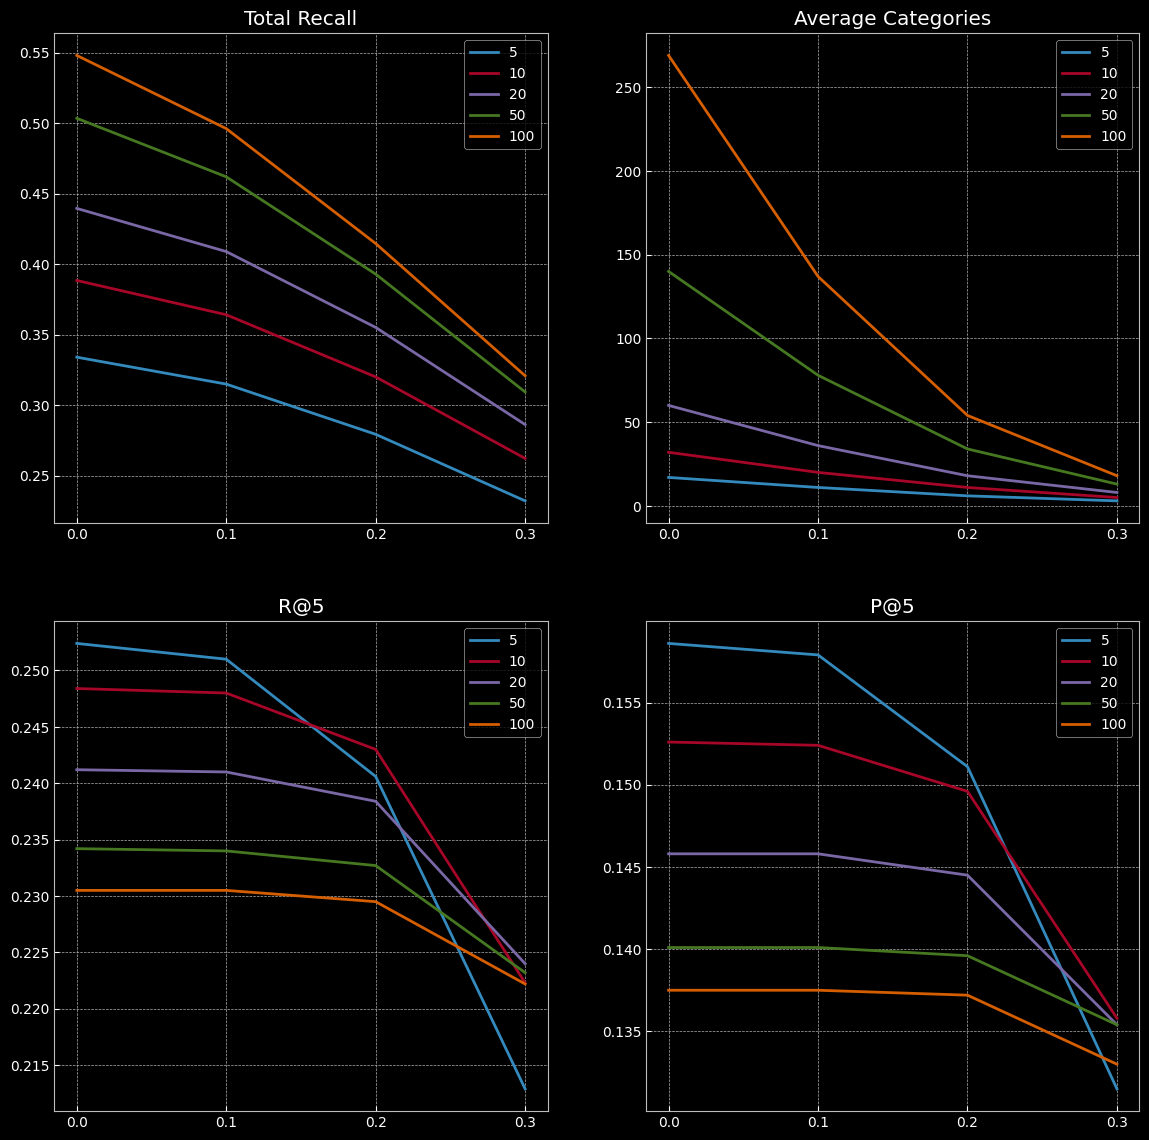

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14,14))

def plot(f, ax):
    for key,value in results.items():
        x,y = zip(*[(k,v[f]) for k,v in value.items()])
        ax.plot(x, y)
    ax.legend(list(results.keys()))
    ax.set_label('$threshold$')
    ax.set_label('$recall$')
    ax.set_title(f'{f}')

plot('Total Recall', ax[0,0])
plot('Average Categories', ax[0,1])
plot('R@5', ax[1,0])
plot('P@5', ax[1,1])
